In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *
from fastai.metrics import accuracy, error_rate
from fastai.callback.all import *
import seaborn as sns
import random
from rembg import remove, new_session
import shutil
from sklearn.model_selection import train_test_split

In [3]:
# Set seed for reproducibility
set_seed(42)

In [4]:

# Define paths - modify these to match your actual directory structure
base_dir = Path("./data")  # Change this to your actual base directory
train_csv_path = base_dir/"Training_set.csv"
test_csv_path =  base_dir/"Testing_set.csv"
images_dir = base_dir/"train"  #

# Create directories for organized data
rembg_dir = base_dir/"rembg"
os.makedirs(rembg_dir, exist_ok=True)
train_dir = rembg_dir/"train"
os.makedirs(train_dir, exist_ok=True)
test_dir = rembg_dir/"test"
os.makedirs(test_dir, exist_ok=True)

In [5]:

# Display random images without labels
def show_images_without_label(images_path, n=9):
    """
    Display random images from the specified directory without labels
    """
    try:
        images = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        if not images:
            print(f"No images found in {images_path}")
            return
            
        random_images = np.random.choice(images, size=min(n, len(images)))
        
        plt.figure(figsize=(10, 10))
        for i, image in enumerate(random_images):
            img_path = os.path.join(images_path, image)
            try:
                img = Image.open(img_path)
                plt.subplot(3, 3, i+1)
                plt.imshow(img)
                plt.axis("off")
            except Exception as e:
                print(f"Error displaying image {image}: {e}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error showing images from {images_path}: {e}")

In [7]:

# Load and preprocess the CSV file
def load_and_preprocess_csv(csv_path):
    """Load and preprocess the CSV file with image labels"""
    try:
        df = pd.read_csv(csv_path)
        # Convert jpg extensions to png since background removal saves as png
        if 'filename' in df.columns:
            df['filename'] = df['filename'].str.replace('.jpg', '.png', regex=False)
        else:
            print(f"Warning: CSV at {csv_path} doesn't have a 'filename' column")
        return df
    except Exception as e:
        print(f"Error loading CSV from {csv_path}: {e}")
        return None

In [8]:

# Show label distribution
def show_distribution(df):
    """Show the distribution of labels in the dataset"""
    if df is None or 'label' not in df.columns:
        print("Cannot show distribution: Invalid dataframe or missing 'label' column")
        return
        
    plt.figure(figsize=(15, 10))
    ax = sns.countplot(data=df, x="label", order=df['label'].value_counts().index)
    plt.title('Label Distribution', fontsize=16)
    plt.xlabel('Labels')
    plt.ylabel('Image Count')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


In [9]:
def organize_images(dataframe, source_dir, dest_parent_dir, split_type):
    """
    Organize images from source directory into class-specific folders
    
    Args:
        dataframe: DataFrame containing 'filename' and 'label' columns
        source_dir: Directory containing the source images
        dest_parent_dir: Parent directory where split_type folder will be created
        split_type: Type of split (e.g., 'train' or 'test')
    """
    # Create the destination directory for this split
    dest_split_dir = os.path.join(dest_parent_dir, split_type)
    os.makedirs(dest_split_dir, exist_ok=True)
    
    # Track progress and issues
    total = len(dataframe)
    copied = 0
    errors = 0
    
    # Process each image
    for idx, row in dataframe.iterrows():
        try:
            image_name = row['filename']
            label = row['label']
            
            # Source path - try both with and without extension
            src_path = os.path.join(source_dir, image_name)
            if not os.path.exists(src_path):
                # Try with .jpg extension
                base_name = os.path.splitext(image_name)[0]
                alt_src_path = os.path.join(source_dir, f"{base_name}.jpg")
                if os.path.exists(alt_src_path):
                    src_path = alt_src_path
                else:
                    print(f"Warning: Image not found: {image_name}")
                    errors += 1
                    continue
            
            # Create class directory if it doesn't exist
            class_dir = os.path.join(dest_split_dir, str(label))
            os.makedirs(class_dir, exist_ok=True)
            
            # Destination path
            dest_path = os.path.join(class_dir, image_name)
            
            # Copy the file
            shutil.copy(src_path, dest_path)
            copied += 1
            
            # Show progress
            if idx % 100 == 0:
                print(f"Progress: {idx}/{total} images processed")
        
        except Exception as e:
            print(f"Error processing {row['filename']}: {str(e)}")
            errors += 1
    
    print(f"Finished organizing {split_type} set:")
    print(f"- Successfully copied: {copied}/{total} images")
    print(f"- Errors: {errors}/{total} images")
    
    # Return the directory containing the organized images
    return dest_split_dir

In [10]:
import os
import random
import numpy as np
import cv2
import torch
from torchvision import transforms

def balance_dataset(train_dir, target_size=None):
    """
    Balance the dataset by downsampling majority classes and augmenting minority classes.
    
    Args:
        train_dir (str): Root directory with class subdirectories.
        target_size (int or None): Target size per class. If None, median is used.
        
    Returns:
        int: The final target size per class.
    """
    class_counts = {}
    
    # Count number of images in each class folder
    for class_name in os.listdir(train_dir):
        class_dir = os.path.join(train_dir, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    
    if not class_counts:
        print(f"No class directories found in {train_dir}")
        return 0
    
    # Determine target size
    if target_size is None:
        target_size = int(np.median(list(class_counts.values())))
    
    print(f"Target size per class: {target_size}")
    
    # Downsample
    for class_name, count in class_counts.items():
        class_dir = os.path.join(train_dir, class_name)
        images = os.listdir(class_dir)
        
        if count > target_size:
            to_keep = set(random.sample(images, target_size))
            for img in images:
                if img not in to_keep:
                    try:
                        os.remove(os.path.join(class_dir, img))
                    except Exception as e:
                        print(f"Error removing {img}: {e}")
            print(f"{class_name} downsampled: {count} -> {target_size}")
    
    # Define torchvision transform pipeline (tensor-based, no PIL)
    aug_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
        transforms.ToPILImage(),  # required to save with OpenCV later
    ])
    
    # Upsample
    for class_name, count in class_counts.items():
        class_dir = os.path.join(train_dir, class_name)
        images = os.listdir(class_dir)
        needed = target_size - len(images)
        
        if needed <= 0:
            continue
        
        for i in range(needed):
            try:
                img_name = random.choice(images)
                img_path = os.path.join(class_dir, img_name)
                
                # Read image using OpenCV
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read {img_path}")
                    continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = aug_transform(img)
                img = np.array(img)  # Convert back from PIL to NumPy array
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                
                new_img_path = os.path.join(class_dir, f"aug_{i}_{img_name}")
                cv2.imwrite(new_img_path, img)
            except Exception as e:
                print(f"Error augmenting {img_name}: {e}")
        
        print(f"{class_name} upsampled: {count} -> {target_size}")
    
    return target_size


In [11]:
# Create FastAI DataLoaders
def create_dataloaders(train_dir, img_size=224, bs=32, valid_pct=0.2):
    """
    Create FastAI DataLoaders for training and validation
    
    Args:
        train_dir: Directory containing class subdirectories
        img_size: Size to resize images to
        bs: Batch size
        valid_pct: Percentage of data to use for validation
        
    Returns:
        FastAI DataLoaders object
    """
    try:
        # Check if directory exists and has data
        if not os.path.exists(train_dir):
            print(f"Error: Directory {train_dir} does not exist")
            return None
            
        class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
        if not class_dirs:
            print(f"Error: No class directories found in {train_dir}")
            return None
            
        # Define data augmentation transforms
        item_tfms = [Resize(img_size)]
        batch_tfms = [
            *aug_transforms(flip_vert=False, max_rotate=30.0, max_zoom=1.2, max_lighting=0.5),
            Normalize.from_stats(*imagenet_stats)
        ]
        
        # Create DataLoaders with validation split
        dls = ImageDataLoaders.from_folder(
            train_dir,
            valid_pct=valid_pct,
            seed=42,
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
            bs=bs
        )
        
        print(f"Created DataLoaders with {len(dls.train_ds)} training and {len(dls.valid_ds)} validation items")
        print(f"Classes: {dls.vocab}")
        
        return dls
    except Exception as e:
        print(f"Error creating DataLoaders: {e}")
        return None


In [12]:
from fastai.vision.all import *

def train_deep_cnn_model(dls, epochs=15, lr=1e-3):
    """
    Train a deeper CNN model from scratch, suited for 76-class classification.
    
    Args:
        dls: DataLoaders object
        epochs: Number of epochs
        lr: Learning rate
    
    Returns:
        Trained Learner object
    """
    if dls is None:
        print("Error: Cannot train model with None DataLoaders")
        return None

    try:
        # Define a deeper CNN architecture
        class DeepCNN(nn.Module):
            def __init__(self, num_classes):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.MaxPool2d(2),

                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(2),

                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.MaxPool2d(2),

                    nn.Conv2d(128, 256, kernel_size=3, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool2d((1, 1))
                )
                self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Dropout(0.5),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(128, num_classes)
                )

            def forward(self, x):
                x = self.features(x)
                return self.classifier(x)

        # Instantiate model
        model = DeepCNN(num_classes=dls.c)

        # Create learner
        learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate])

        print(f"📊 Training Deep CNN for {epochs} epochs...")
        learn.fit_one_cycle(epochs, lr)

        print("\n🔍 Interpreting the model...")
        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix(figsize=(8,8), dpi=100)
        interp.plot_top_losses(9, nrows=3, figsize=(10,10))

        return learn

    except Exception as e:
        print(f"Error training deep CNN: {e}")
        return None


In [35]:
# Define and train the model
def train_transfer_learning_resnet_model(dls, epochs=5, freeze_epochs=5):
    """    
    Args:
        dls: DataLoaders object
        epochs: Number of epochs for fine-tuning
        freeze_epochs: Number of epochs for training with frozen layers
        
    Returns:
        Trained Learner object
    """
    if dls is None:
        print("Error: Cannot train model with None DataLoaders")
        return None
        
    try:
        # Create learner using resnet34 as backbone
        learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate])
        
        # Find optimal learning rate
        lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
        print(f"Minimum/10: {lr_min/10:.2e}, Steepest point: {lr_steep:.2e}")
        
        # Train model with frozen layers first
        print(f"\nTraining with frozen backbone for {freeze_epochs} epochs...")
        learn.fit_one_cycle(freeze_epochs, lr_steep)
        
        # Unfreeze and continue training with discriminative learning rates
        print(f"\nUnfreezing and fine-tuning for {epochs} epochs...")
        learn.unfreeze()
        learn.fit_one_cycle(epochs, slice(lr_min/10, lr_steep/5))
        
        return learn
    except Exception as e:
        print(f"Error training model: {e}")
        return None

In [67]:
from sklearn.metrics import accuracy_score
from fastai.vision.all import *

def evaluate_model(learn, test_folder):
    """
    Evaluate the model using a folder-based test dataset (ImageNet style).
    
    Args:
        learn: Trained Learner object
        test_folder: Path to the test folder organized by class subfolders
    """
    if learn is None or test_folder is None:
        print("Error: Missing model or test folder")
        return

    try:
        # Create a dataloader from the test folder
        test_dl = learn.dls.test_dl(get_image_files(test_folder), with_labels=True)

        # Get predictions
        preds, targs = learn.get_preds(dl=test_dl)
        pred_classes = preds.argmax(dim=1)

        # Compute accuracy
        acc = accuracy_score(targs, pred_classes)
        err = 1 - acc

        # Confusion matrix and top losses
        interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
        interp.plot_confusion_matrix(figsize=(12, 12))
        plt.title("Confusion Matrix")
        plt.show()

        interp.plot_top_losses(9, figsize=(15, 11))
        plt.title("Top Losses")
        plt.show()

        print("\nTest Set Metrics:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Error Rate: {err:.4f}")

    except Exception as e:
        print(f"Error evaluating model: {e}")


In [27]:
# 1. Load and preprocess CSV
train_df = load_and_preprocess_csv(train_csv_path)
if train_df is None:
    print("Error: Could not load training data CSV")

no_label_df = load_and_preprocess_csv(test_csv_path)

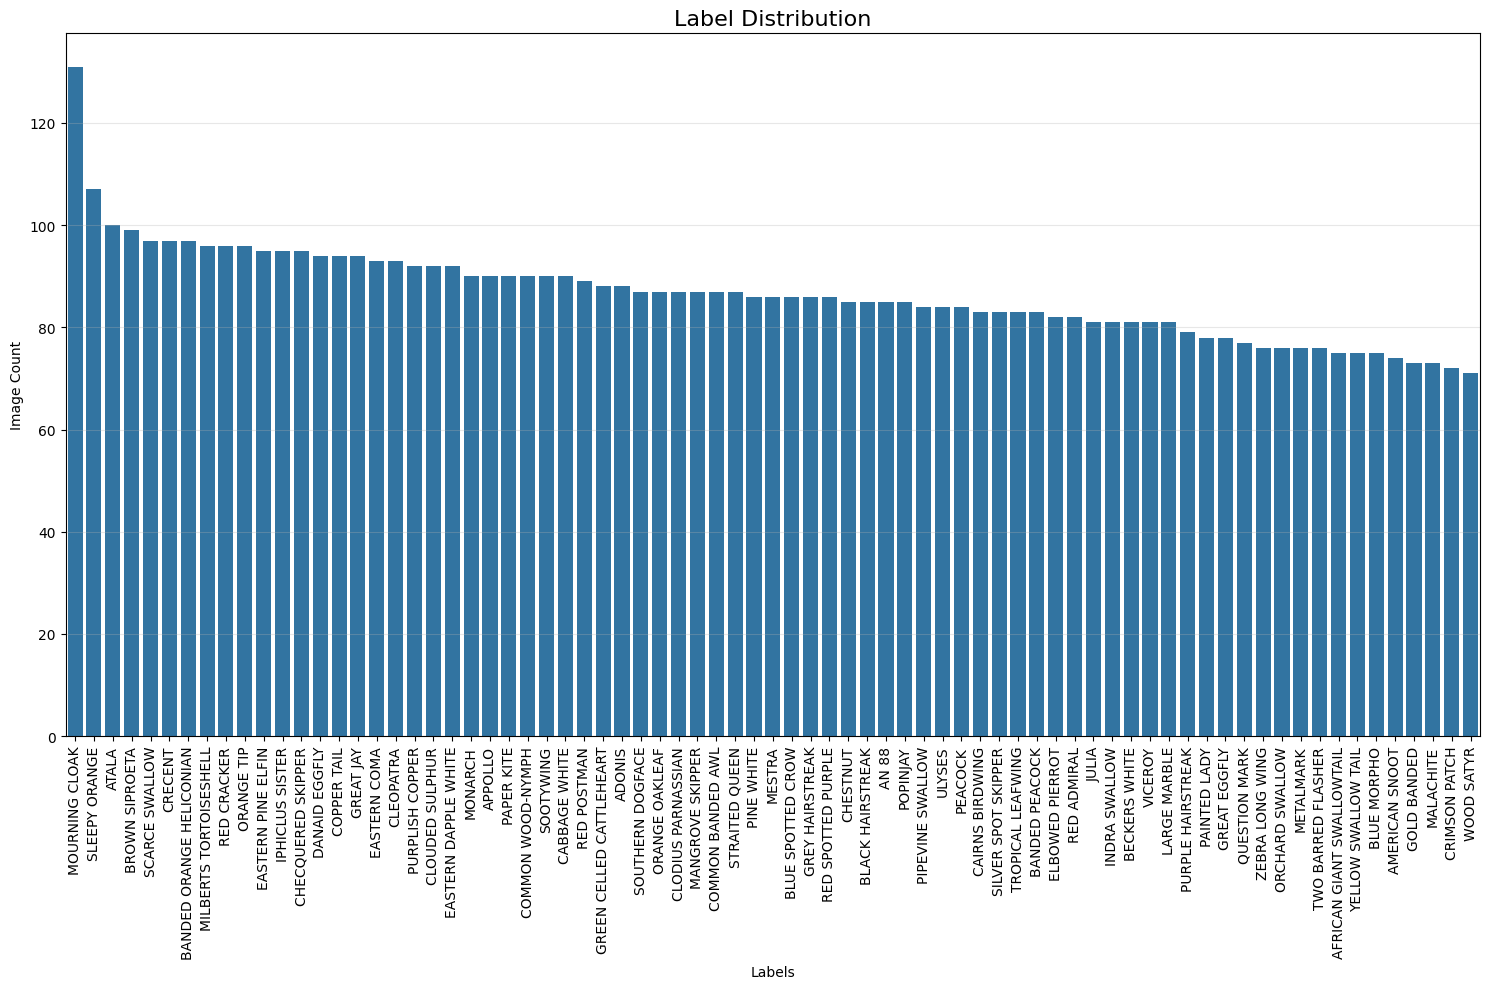

In [25]:
# 2. Show initial distribution
show_distribution(train_df)

In [29]:
train_subset, test_subset = train_test_split(
        train_df, 
        test_size=0.15, 
        random_state=42, 
        stratify=train_df['label']
    )
print(f"Train set: {len(train_subset)} images")
print(f"Test set: {len(test_subset)} images")

Train set: 5524 images
Test set: 975 images


In [64]:
train_split_dir = organize_images(
    train_subset, 
    source_dir=images_dir,  # Directory containing all images
    dest_parent_dir=rembg_dir,  # Parent directory for organized images
    split_type="train"
)

test_split_dir = organize_images(
    test_subset, 
    source_dir=images_dir,
    dest_parent_dir=rembg_dir,
    split_type="test"
)

Progress: 1400/5524 images processed
Progress: 5300/5524 images processed
Progress: 5500/5524 images processed
Progress: 3700/5524 images processed
Progress: 2900/5524 images processed
Progress: 700/5524 images processed
Progress: 1600/5524 images processed
Progress: 4800/5524 images processed
Progress: 6100/5524 images processed
Progress: 2000/5524 images processed
Progress: 4300/5524 images processed
Progress: 2300/5524 images processed
Progress: 6200/5524 images processed
Progress: 4600/5524 images processed
Progress: 2500/5524 images processed
Progress: 300/5524 images processed
Progress: 3300/5524 images processed
Progress: 5400/5524 images processed
Progress: 500/5524 images processed
Progress: 3600/5524 images processed
Progress: 1300/5524 images processed
Progress: 1000/5524 images processed
Progress: 2200/5524 images processed
Progress: 2400/5524 images processed
Progress: 3200/5524 images processed
Progress: 5600/5524 images processed
Progress: 1500/5524 images processed
Prog

In [31]:
# 6. Balance the dataset

train_dir = rembg_dir/"train"
target_size = balance_dataset(train_dir)

Target size per class: 86
ADONIS downsampled: 88 -> 86
APPOLLO downsampled: 90 -> 86
ATALA downsampled: 100 -> 86
BANDED ORANGE HELICONIAN downsampled: 97 -> 86
BROWN SIPROETA downsampled: 99 -> 86
CABBAGE WHITE downsampled: 90 -> 86
CHECQUERED SKIPPER downsampled: 95 -> 86
CLEOPATRA downsampled: 93 -> 86
CLODIUS PARNASSIAN downsampled: 87 -> 86
CLOUDED SULPHUR downsampled: 92 -> 86
COMMON BANDED AWL downsampled: 87 -> 86
COMMON WOOD-NYMPH downsampled: 90 -> 86
COPPER TAIL downsampled: 94 -> 86
CRECENT downsampled: 97 -> 86
DANAID EGGFLY downsampled: 94 -> 86
EASTERN COMA downsampled: 93 -> 86
EASTERN DAPPLE WHITE downsampled: 92 -> 86
EASTERN PINE ELFIN downsampled: 95 -> 86
GREAT JAY downsampled: 94 -> 86
GREEN CELLED CATTLEHEART downsampled: 88 -> 86
IPHICLUS SISTER downsampled: 95 -> 86
MANGROVE SKIPPER downsampled: 87 -> 86
MILBERTS TORTOISESHELL downsampled: 96 -> 86
MONARCH downsampled: 90 -> 86
MOURNING CLOAK downsampled: 131 -> 86
ORANGE OAKLEAF downsampled: 87 -> 86
ORANGE TI

In [32]:
# 7. Create DataLoaders
dls = create_dataloaders(train_dir, img_size=224, bs=64)

Created DataLoaders with 5160 training and 1290 validation items
Classes: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PAPER KITE', 'PEACOCK', 'PINE WHITE', 'PIPEVINE SWALLOW', 'POPIN

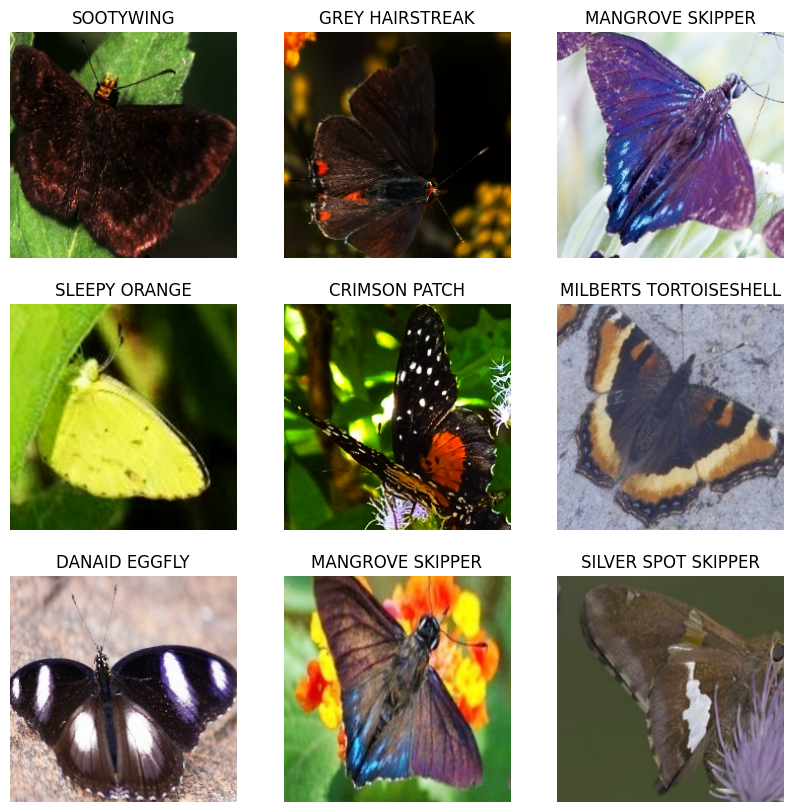

In [34]:
# 5. Show some sample images
dls.show_batch(max_n=9, figsize=(10, 10))

📊 Training Deep CNN for 5 epochs...



🔍 Interpreting the model...


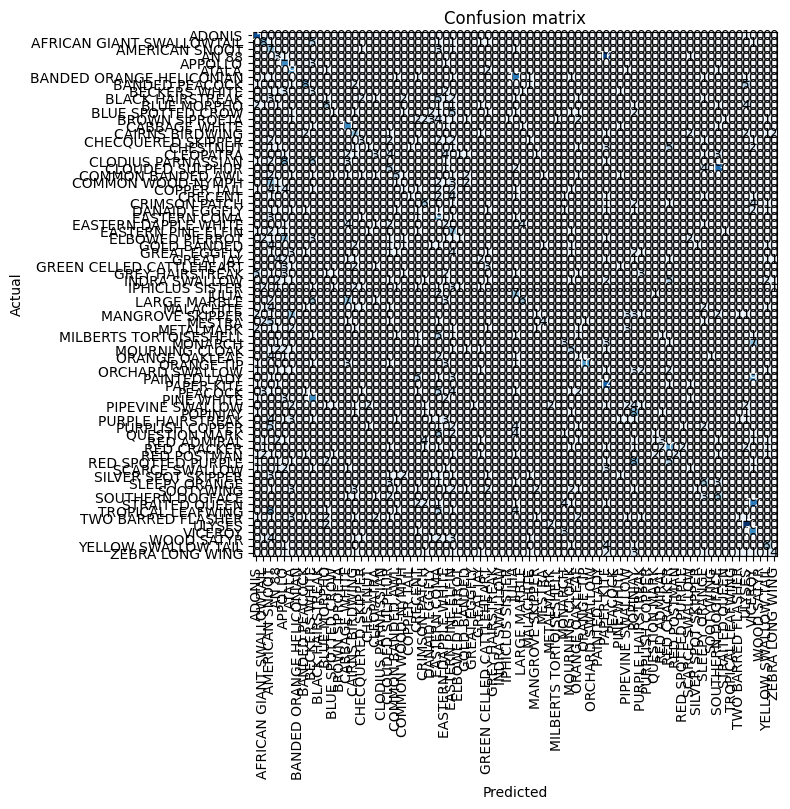

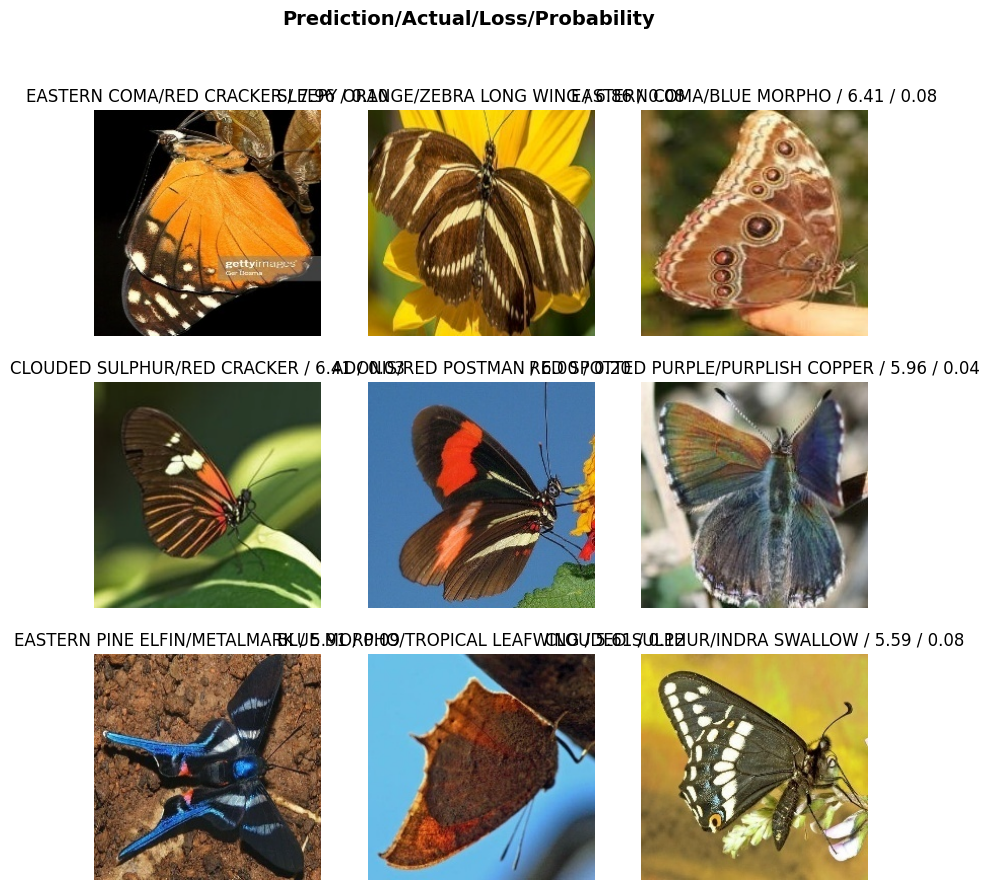

In [39]:
learn = train_deep_cnn_model(dls, epochs=5, lr=1e-3)

lr: 1.00e-08, loss: 0.1261


lr: 2.00e-08, loss: 0.1790


lr: 4.00e-08, loss: 0.1098


lr: 8.00e-08, loss: 0.1720


lr: 1.60e-07, loss: 0.3157


lr: 3.20e-07, loss: 0.2763


lr: 6.40e-07, loss: 0.0920


lr: 1.28e-06, loss: 0.1750


lr: 2.56e-06, loss: 0.1248


lr: 5.12e-06, loss: 0.3201


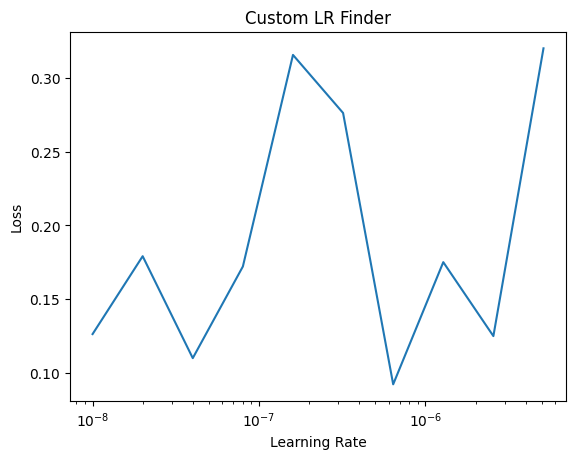

In [33]:
import matplotlib.pyplot as plt

def custom_lr_finder(learn, start_lr=1e-8, max_lr=1, factor=2):
    lrs = []
    losses = []
    lr = start_lr
    old_loss = float('inf')

    while lr <= max_lr*2:
        learn.fit(1, lr, wd=0, cbs=[SingleBatchCB()])
        new_loss = learn.recorder.losses[0].item()

        lrs.append(lr)
        losses.append(new_loss)

        print(f"lr: {lr:.2e}, loss: {new_loss:.4f}")
        if new_loss > old_loss*2:
            break
        old_loss = new_loss
        lr *= factor

    # Plotting
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Custom LR Finder')
    plt.show()


class SingleBatchCB(Callback):
    def before_batch(self): self.learn.dl.stop = True


custom_lr_finder(learn)


Minimum/10: 1.20e-03, Steepest point: 1.10e-02

Training with frozen backbone for 5 epochs...


C:\Users\deniz\Miniconda3\Lib\site-packages\fastai\learner.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kw


Unfreezing and fine-tuning for 5 epochs...


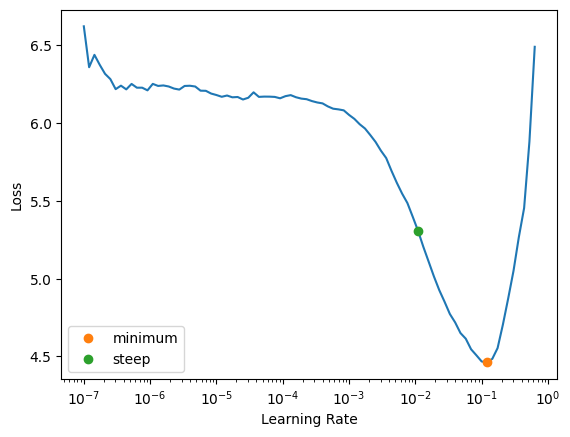

In [36]:
# 6. Train the model
learn = train_transfer_learning_resnet_model(dls, epochs=5)

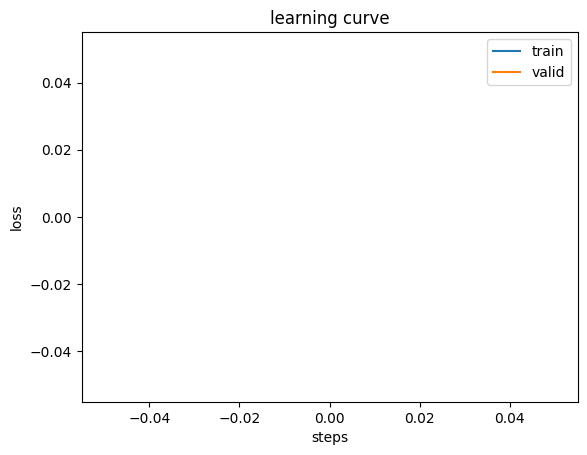

ValueError: not enough values to unpack (expected 3, got 2)

In [55]:
# 7. Plot training results
learn.recorder.plot_loss()
plt.show()

# 8. Show classification results with confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12))
plt.show()

# 9. Show top losses
interp.plot_top_losses(9, figsize=(15, 11))
plt.show()

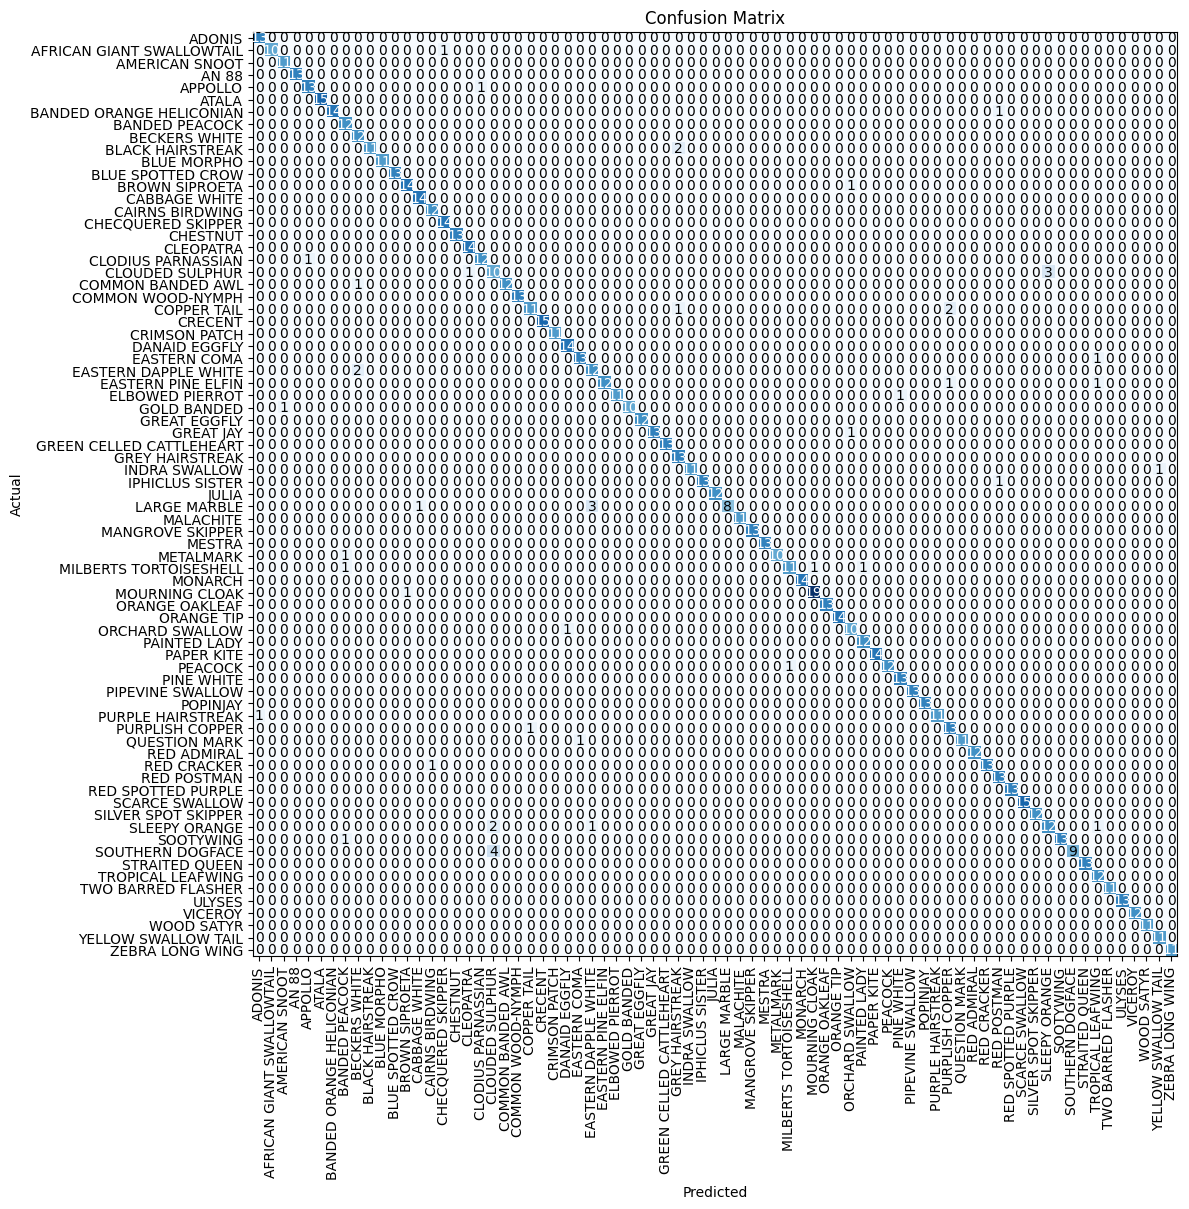

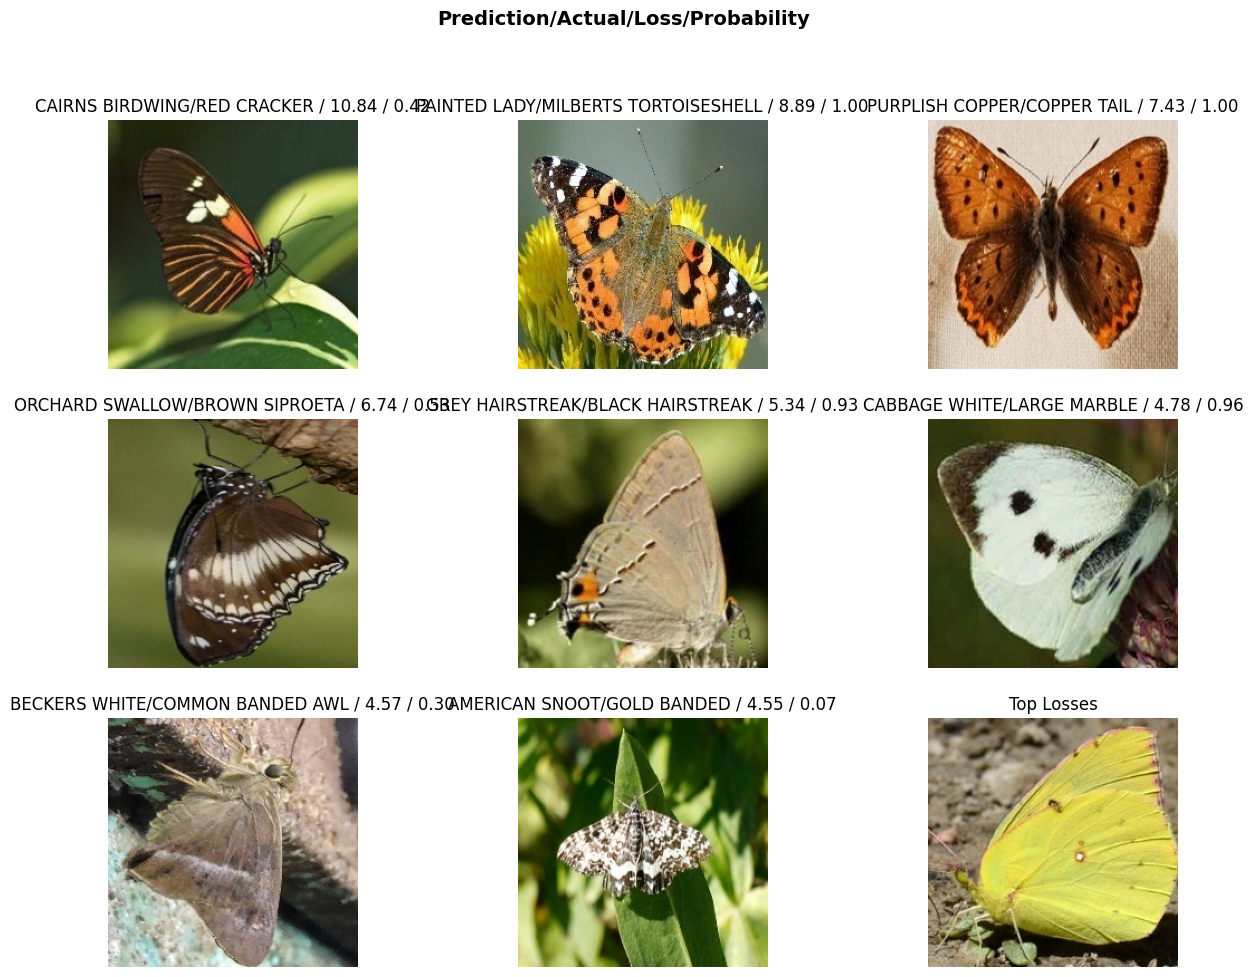


Test Set Metrics:
Accuracy: 0.9497
Error Rate: 0.0503


In [69]:
evaluate_model(learn, test_dir)

In [51]:
export_path = r'C:\Users\deniz\Desktop\butterfly classification\butterfly_classifier.pkl'
learn.export(export_path)
print("Exported:", os.path.exists(export_path))


Exported: True


In [70]:
from fastai.vision.all import *
import gradio as gr

learn = load_learner('butterfly_classifier.pkl')

def predict(img):
    pred_class, pred_idx, probs = learn.predict(img)
    return {learn.dls.vocab[i]: float(probs[i]) for i in range(len(probs))}
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        # 🦋 Butterfly Classifier
        Upload a butterfly image, and the model will predict its species from 75 categories.
        """)
    
    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="Upload Butterfly Image")
            predict_btn = gr.Button("Classify")
        with gr.Column():
            output = gr.Label(num_top_classes=5, label="Top Predictions")

    predict_btn.click(fn=predict, inputs=image_input, outputs=output)

demo.launch()


C:\Users\deniz\Miniconda3\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
